<a href="https://colab.research.google.com/github/lszam/southamerica_prmantle/blob/main/prmantle_surfaces___figures_for_the_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Surfaces over oceanic relicts beneath Paraná Basin based on the UU-P07 model (Jupyter Notebook)**
This Jupyter Notebook was created in order to generate a 3D overview of surfaces interpreted in the flooring mantle of the Paraná Basin. Those surfaces cover oceanic relicts, which were interpreted in a 3D seismic tomographic model (UU-P07; Amaru, 2007; Hall and Spakman, 2015). The surfaces were picked using Oasis Montaj software (Seequent) and exported as SHP files (point type). Subsequently, these SHP files were imported into this notebook using the Google Colaboratory environment.

References:

Seismic tomography:
Amaru, M. (2007). Global travel time tomography with 3-D reference models (p. 174).
Hall, R., & Spakman, W.. (2015). Mantle structure and tectonic history of SE Asia. Tectonophysics, 658, 14–45.

Basin and structures:
Cordani, U. G., Ramos, V. A., Fraga, L. M., Cegarra, M., Delgado, I., Souza, K.G., Gomes, F. E. M. & Schobbenhaus, C. 2016. Tectonic map of South America. 2nd. ed. Paris: CGMW-CPRM-SEGEMAR, 2016. 1 map. Scale 1:5.000.000. https://rigeo.sgb.gov.br/handle/doc/16750

##Running this notebook
###### This routine was designed to run in the Google Colaboratory environment.For running this code successifully, you must create the directory '/content/drive/MyDrive/Colab Notebooks/prmantle_surfaces' with the input files, which are available at the same repository.

######Related GitHub repository: https://github.com/lszam/southamerica_prmantle

######Inspirations for creating this code: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html ; https://www.educative.io/answers/how-to-use-the-scipyinterpolategriddata-method

##Ackowledgements
This study was financed in part by the Coordenação de Aperfeiçoamento de Pessoal de Nível Superior - Brasil (CAPES) - Finance Code 001. Postdoctoral fellow 2022-2024. Title: Caracterização geofísica da região da Zona de Fratura de Florianópolis, Sul da Bacia de Santos – Relação com a margem africana e comparação com falhas transformantes no Atlântico Norte. / Geophysical characterization of Florianópolis Fracture Zone, Southern Santos Basin: the linkage with African margin and comparison with transforming faults in North Atlantic.

##### contact: Luizemara Szameitat (contato@lszameitat.com)


##*Recovering* real world's coords
Picked points are originally located with relative coordinates.

In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString, Polygon
from scipy.interpolate import interp1d
import numpy as np
import os
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.interpolate import griddata
from google.colab import drive
import math

drive.mount('/content/drive')
diretorio = '/content/drive/MyDrive/Colab Notebooks/prmantle_surfaces'

# Recebe SHPs. Os SHPs devem conter a coluna PROFILE,
# indicando em qual linha os pontos foram mapeados (A, B, C, etc)
filename_BASEMAP = str(diretorio +'/map_BASEMAP_17ago23.shp')
gdf_BASEMAP = gpd.read_file(filename_BASEMAP)
filename_PTS = str(diretorio +'/map_pts_map1234.shp')
gdf_PTS = gpd.read_file(filename_PTS)
gdf_PTS

# Extrair as coordenadas X e Y da propriedade "geometry"
gdf_BASEMAP['X'] = gdf_BASEMAP['geometry'].apply(lambda p: p.x)
gdf_BASEMAP['Y'] = gdf_BASEMAP['geometry'].apply(lambda p: p.y)
gdf_BASEMAP['Distance'] = None
gdf_PTS['Distance'] = gdf_PTS['geometry'].apply(lambda p: p.x)
gdf_PTS['Depth'] = gdf_PTS['geometry'].apply(lambda p: p.y)

#Separar as linhas existentes
line_name, pts_name = [], []
#Adicionar valores não repetidos
[line_name.append(item) for item in gdf_BASEMAP.PROFILE if not line_name.count(item)]
[pts_name.append(item) for item in gdf_PTS.PROFILE if not pts_name.count(item)]
print("BASEMAP lines: ", line_name)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
BASEMAP lines:  ['A', 'AA', 'AB', 'AC', 'AD', 'AE', 'AF', 'AG', 'AH', 'AI', 'AJ', 'AK', 'AL', 'AM', 'AN', 'AO', 'AP', 'AQ', 'AR', 'AS', 'AT', 'AU', 'AV', 'AW', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'AX', 'AY', 'AZ']


In [2]:
#-----------------------------------------
# RECOVERING REAL WORLD COORS X,Y (metric)
#-----------------------------------------

n_surfaces = 4 #number of intended surfaces
df_PTS_REAL_XY = pd.DataFrame(columns=['PROFILE','X','Y','LONG','LAT','Z','S'])

#Iteration over the identified lines (from A to AW)
for i in range(len(line_name)):

  # DISTANCES
  # Select line
  LINE = gdf_BASEMAP[(gdf_BASEMAP['PROFILE'] == line_name[i])]
  LINE_XY = LineString(LINE[['X', 'Y']].values)
  # Calc the cumulative distance along the LINE
  LINE.loc[:, 'Distance'] = LINE['X'].apply(lambda x: LINE_XY.project(Point(x, LINE.loc[LINE['X'] == x, 'Y'].iloc[0])))

  # INTERPOLATION
  # Interpolating function for LINE data
  interpolador_x = interp1d(LINE['Distance'], LINE['X'],
                            fill_value='extrapolate', kind = 'linear',
                            assume_sorted = False)
  interpolador_y = interp1d(LINE['Distance'], LINE['Y'],
                            fill_value='extrapolate', kind = 'linear',
                            assume_sorted = False)

  # OBTAINING PICKED POINTS
  for s in range (1, n_surfaces+1):
    PTS_S = gdf_PTS[(gdf_PTS['PROFILE']==line_name[i]) & (gdf_PTS['S']==s)]
    PTS_S_FINAL = []
    # Iteration over the SHP with picked points
    for j in range(len(PTS_S)):
      dist = PTS_S['Distance'].values[j] # relative distance
      # Obtaining coords XY (interpolated)
      x_interpolado  = float(interpolador_x(dist))
      y_interpolado = float(interpolador_y(dist))
      # Adding coords XY to the list
      PTS_S_FINAL.append((line_name[i], x_interpolado, y_interpolado,
                          PTS_S['Depth'].values[j],PTS_S['S'].values[j]))
    #From list to DataFrame
    PTS_S_FINAL = pd.DataFrame(PTS_S_FINAL, columns=['PROFILE', 'X', 'Y',
                                                     'Z', 'S'])
    #Joining the data
    df_PTS_REAL_XY = pd.concat([df_PTS_REAL_XY, PTS_S_FINAL], ignore_index=True)

df_PTS_REAL_XY = df_PTS_REAL_XY.sort_values(by=['Y', 'X'])

In [3]:
#--------------------------
# RECOVERING GEOGRAPHIC X,Y
#--------------------------

import pyproj
# Object for the project transform
project = pyproj.Transformer.from_crs("epsg:3395", "epsg:4326", always_xy=True)

df_PTS_REAL_XY['X'] = df_PTS_REAL_XY['X'] * 1000
df_PTS_REAL_XY['Y'] = df_PTS_REAL_XY['Y'] * 1000

df_PTS_REAL_XY[['LONG', 'LAT']] = df_PTS_REAL_XY.apply(
    lambda row: project.transform(row['X'], row['Y']), axis=1,
    result_type='expand')

df_PTS_REAL_XY['X'] = df_PTS_REAL_XY['X'] / 1000
df_PTS_REAL_XY['Y'] = df_PTS_REAL_XY['Y'] / 1000

df_PTS_REAL_XY

,PROFILE,X,Y,LONG,LAT,Z,S
2295,AX,-6015.029272,-3813.168105,-54.033927,-32.553276,-52.856451,4.0
2305,AY,-6100.096949,-3813.038331,-54.798103,-32.552289,-53.136607,4.0
1159,AW,-5934.723610,-3811.548648,-53.312529,-32.540955,-52.724893,4.0
2294,AX,-6022.023296,-3807.825730,-54.096756,-32.512622,-43.933106,4.0
2304,AY,-6115.997103,-3800.904003,-54.940937,-32.459921,-41.647539,4.0
...,...,...,...,...,...,...,...
8,A,-5847.021473,-1620.101763,-52.524688,-14.492565,-150.880521,2.0
1195,C,-5578.429112,-1617.903678,-50.111881,-14.473325,-39.618214,2.0
1239,D,-5450.278720,-1617.544421,-48.960687,-14.470181,-41.828236,2.0
9,A,-5820.512573,-1610.359976,-52.286554,-14.407285,-159.009649,2.0


In [4]:
#--------------------------
# VANISHING INFINITE POINTS
#--------------------------
#(for solving points that are out of the line)
df_PTS_REAL_XY.replace([np.inf, -np.inf], np.nan, inplace=True)
# Dropping NaN lines
df_PTS_REAL_XY.dropna(inplace=True)

# Splitting data for each surface
df_PTS_REAL_XY_map1 = df_PTS_REAL_XY[df_PTS_REAL_XY.apply(lambda s: s['S'] == 1, axis=1)]
df_PTS_REAL_XY_map2 = df_PTS_REAL_XY[df_PTS_REAL_XY.apply(lambda s: s['S'] == 2, axis=1)]
df_PTS_REAL_XY_map3 = df_PTS_REAL_XY[df_PTS_REAL_XY.apply(lambda s: s['S'] == 3, axis=1)]
df_PTS_REAL_XY_map4 = df_PTS_REAL_XY[df_PTS_REAL_XY.apply(lambda s: s['S'] == 4, axis=1)]

#Output with real world's coords
df_PTS_REAL_XY_map1.to_csv( diretorio + '/S1_realxy.csv')
df_PTS_REAL_XY_map2.to_csv( diretorio + '/S2_realxy.csv')
df_PTS_REAL_XY_map3.to_csv( diretorio + '/S3_realxy.csv')
df_PTS_REAL_XY_map4.to_csv( diretorio + '/S4_realxy.csv')

##Creating a regular grid and calc of surface's azimuths

In [5]:
# ----------
# PARAMETERS
# ----------
n_surfaces = 4
cell = int(50)
s_lista = [1,2,4,3] # ordering the plotting surfaces
#---------------------------------------------------

S_interp = pd.DataFrame()

for i in s_lista:
  # Defining a regular grid for the interpolated data
  X = df_PTS_REAL_XY[df_PTS_REAL_XY['S']==i]['X'].values
  Y = df_PTS_REAL_XY[df_PTS_REAL_XY['S']==i]['Y'].values
  Z = df_PTS_REAL_XY[df_PTS_REAL_XY['S']==i]['Z'].values
  X_new, new_xcoord = [np.ceil(min(X))], np.ceil(min(X))
  Y_new, new_ycoord = [np.ceil(min(Y))], np.ceil(min(Y))

  for xcoord in X:
    while new_xcoord < xcoord:
      new_xcoord = new_xcoord + cell
      X_new.append(new_xcoord)

  for ycoord in Y:
    while new_ycoord < ycoord:
      new_ycoord = new_ycoord + cell
      Y_new.append(new_ycoord)

  xi, yi = np.meshgrid(X_new, Y_new)
  zi = griddata((X, Y), Z, (xi, yi), method='linear')

  # Saving surfaces as csv file
  data_surface_vector = pd.DataFrame({'X': np.ndarray.flatten(xi),
                               'Y': np.ndarray.flatten(yi),
                               'Z': np.ndarray.flatten(zi),
                               'S': i})
  data_surface_vector.to_csv("S"+str(i)+"+_interp.csv")

  #Saving meshgrids
  data_surface_matrix = pd.DataFrame({'X': [xi], 'Y': [yi], 'Z': [zi], 'S': i})
  S_interp = pd.concat([S_interp, data_surface_matrix])

#GEOGRAPHIC COORDS

import pyproj
# Projection transform object - from World Mercator to Geographic (WGS84)
project = pyproj.Transformer.from_crs("epsg:3395", "epsg:4326", always_xy=True)
data_surface_vector['X'] = data_surface_vector['X'] * 1000
data_surface_vector['Y'] = data_surface_vector['Y'] * 1000
data_surface_vector[['LONG', 'LAT']] = data_surface_vector.apply(
    lambda row: project.transform(row['X'], row['Y']), axis=1,
    result_type='expand')
data_surface_vector['X'] = data_surface_vector['X'] / 1000
data_surface_vector['Y'] = data_surface_vector['Y'] / 1000

data_surface_vector

,X,Y,Z,S,LONG,LAT
0,-6624.0,-3273.0,NaN,3,-59.504404,-28.350895
1,-6574.0,-3273.0,NaN,3,-59.055247,-28.350895
2,-6524.0,-3273.0,NaN,3,-58.606089,-28.350895
3,-6474.0,-3273.0,NaN,3,-58.156931,-28.350895
4,-6424.0,-3273.0,NaN,3,-57.707774,-28.350895
...,...,...,...,...,...,...
639,-5474.0,-2173.0,NaN,3,-49.173779,-19.272939
640,-5424.0,-2173.0,NaN,3,-48.724621,-19.272939
641,-5374.0,-2173.0,NaN,3,-48.275463,-19.272939
642,-5324.0,-2173.0,NaN,3,-47.826306,-19.272939


##Map of picked points

In [6]:
cor = ['red', 'green', 'blue', 'purple']
paleta = ['Reds_r', 'Greens_r', 'Blues_r', 'Purples_r']

#Basin outline
gdf_basin = gpd.read_file(diretorio +'/bacia_limite_ln.shp')

#Geological structures
gdf_structures = gpd.read_file( diretorio + '/structures2_ln.shp')


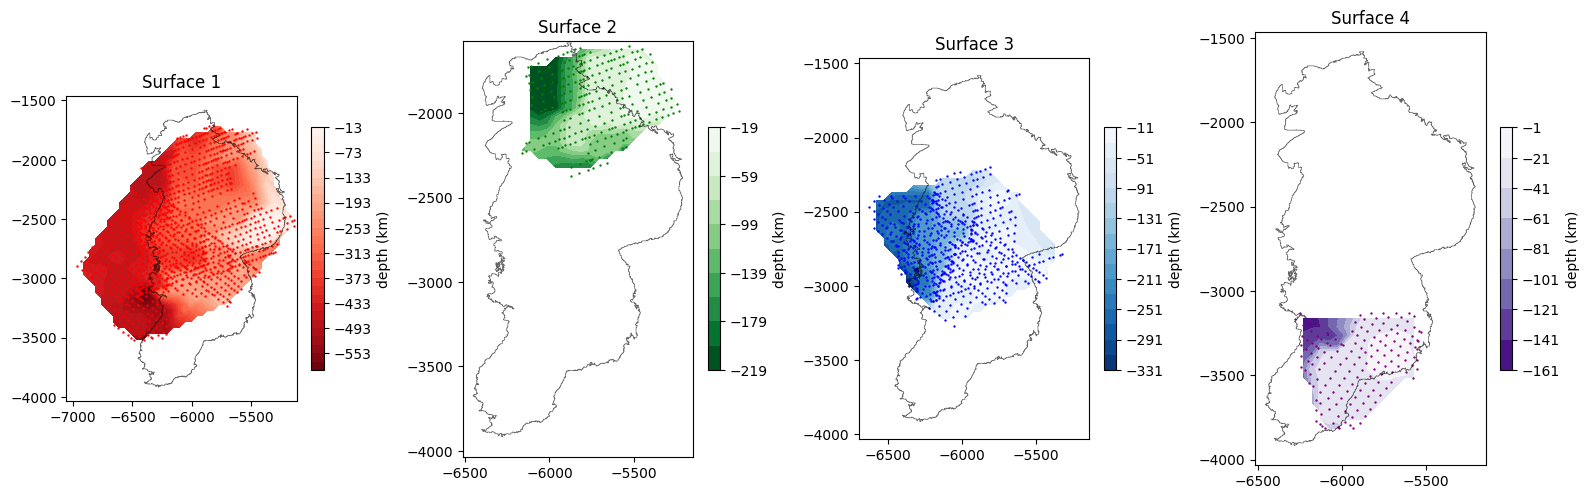

In [7]:
import math

fig, axes = plt.subplots(1, len(s_lista), figsize=(4 * len(s_lista), 10))

for i in s_lista:
    ax = axes[i-1]
    xi = S_interp[S_interp['S'] == i]['X'].values[0]
    yi = S_interp[S_interp['S'] == i]['Y'].values[0]
    zi = S_interp[S_interp['S'] == i]['Z'].values[0]
    zi_temp = np.nan_to_num(zi, nan=0)
    levels = list(range(int(np.min(zi_temp)), int(np.max(zi_temp)), 20))
    #levels = 10
    contour = ax.contourf(xi, yi, zi, levels=levels, cmap=paleta[i - 1])
    cbar = fig.colorbar(contour, ax=ax, shrink=0.25)
    cbar.set_label('depth (km)', fontsize=10)
    ax.scatter(df_PTS_REAL_XY[df_PTS_REAL_XY['S']==i]['X'].values,
               df_PTS_REAL_XY[df_PTS_REAL_XY['S']==i]['Y'].values,
               s=0.5, edgecolor=cor[i-1], alpha=1)

    gdf_basin.plot(ax=ax, facecolor='none', alpha=0.6, edgecolor='black', linewidth=0.5)

    ax.set_title(f'Surface {i}')
    ax.set_aspect("equal")

plt.tight_layout()
plt.show()


##Map of surfaces

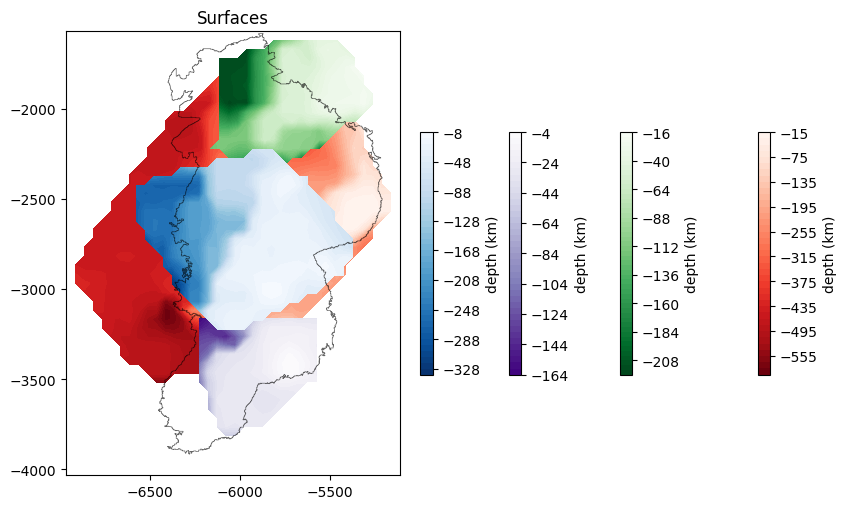

In [8]:
# --------- #
#  FIGURES  #
# --------- #

levels = 50
azim = []

plt.figure(figsize=(9,10))

for i in s_lista:

  xi = S_interp[S_interp['S']==i]['X'].values[0]
  yi = S_interp[S_interp['S']==i]['Y'].values[0]
  zi = S_interp[S_interp['S']==i]['Z'].values[0]
  grad_x, grad_y = np.gradient(zi) #gradient

  plt.contourf(xi, yi, zi, levels=levels,
               cmap=paleta[i-1])
  cbar = plt.colorbar(shrink=0.25)
  cbar.set_label('depth (km)', fontsize=10)

#Basin outiline
gdf_basin.plot(ax=plt.gca(), facecolor='none', alpha = 0.6,
                edgecolor='black', linewidth = 0.5)

plt.title('Surfaces')
plt.gca().set_aspect("equal")
plt.tight_layout()
plt.savefig(
    diretorio + '/py_surfaces_map.png',
    dpi=300)
plt.show()

##Map of azimuths

In [9]:
gdf_basin = gpd.read_file( diretorio + '/bacia_limite_ln.shp')

world_mercator_km_proj = """
+proj=merc
+a=6378137
+b=6378137
+lat_ts=0.0
+lon_0=0.0
+x_0=0.0
+y_0=0
+k=0.001
+units=km
+no_defs
"""
#Janelar - Criar envelope
gdf_combined = gpd.GeoDataFrame(pd.concat([gdf_basin, gdf_BASEMAP], ignore_index=True))
combined_envelope = gdf_combined.unary_union.envelope
envelope_gdf = gpd.GeoDataFrame(gpd.GeoSeries(combined_envelope), columns=['geometry'])
envelope_gdf.crs = world_mercator_km_proj  # define o sistema de coordenadas

#CONTORNO DOS PAISES
import requests
import zipfile
from io import BytesIO
# Download do arquivo zip
url = "https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_countries.zip"
response = requests.get(url)
zip_file = zipfile.ZipFile(BytesIO(response.content))
# Extrair o shapefile
zip_file.extractall("ne_10m_admin_0_countries")
# Carregar o GeoDataFrame
gdf_high_res = gpd.read_file("ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp")
# Transformar para o SCR em uso
gdf_high_res_mercator_km = gdf_high_res.to_crs(world_mercator_km_proj)

# Linhas dos limites - Obter apenas as linhas
boundaries_high_res = gdf_high_res_mercator_km.boundary
# Linhas dos limites - Criar um GeoDataFrame para as linhas de contorno
boundaries_gdf = gpd.GeoDataFrame(geometry=boundaries_high_res)
boundaries_gdf.crs = world_mercator_km_proj

# Coordenadas do corte
coords = [(-7100000, -4100000), (-7100000, -1500000), (-5000000, -1500000), (-5000000, -4100000)]
cut_polygon = Polygon(coords)
data = {'geometry': [cut_polygon]}# Cria um GeoDataFrame
polygon_gdf = gpd.GeoDataFrame(data, crs=3395)
polygon_gdf = polygon_gdf.to_crs(world_mercator_km_proj)

# Linhas dos limites - Interseção com a área de interesse
lines_in_area = gpd.overlay(boundaries_gdf, polygon_gdf, how="intersection")

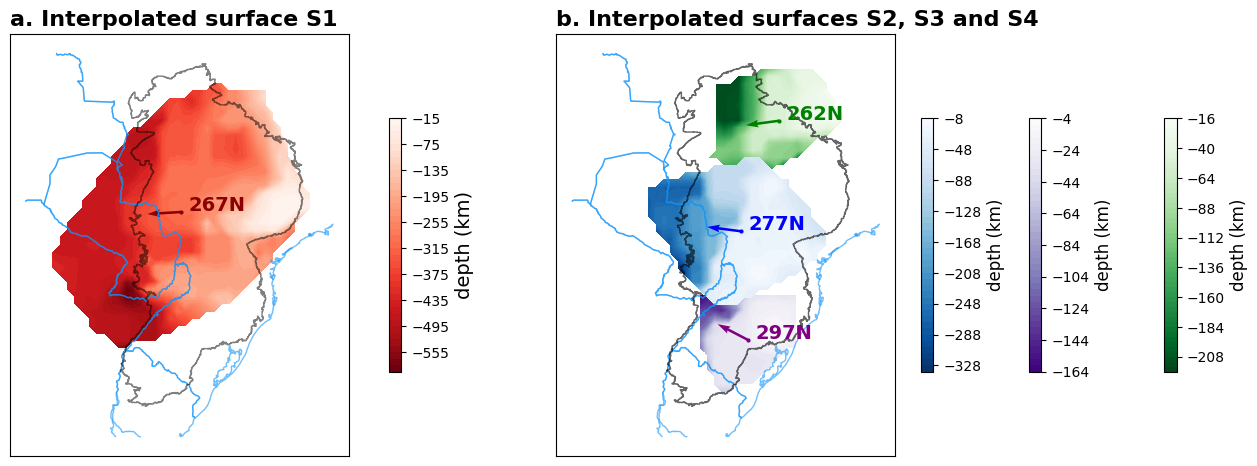

In [10]:

cor = ['darkred', 'green', 'blue', 'purple']


plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
#S1:
i=1
xi = S_interp[S_interp['S']==i]['X'].values[0] #[0] para puxar o array do array...
yi = S_interp[S_interp['S']==i]['Y'].values[0]
zi = S_interp[S_interp['S']==i]['Z'].values[0]
#Obter o azimute
grad_x, grad_y = np.gradient(zi) #gradiente da superfície
grad_x = np.nan_to_num(grad_x, nan=0) # Substituir NaN por 0
grad_y = np.nan_to_num(grad_y, nan=0) # Substituir NaN por 0
azim_med = np.degrees(np.arctan2(np.mean(grad_x), np.mean(grad_y))) #azimute médio
real_azim = abs(azim_med - 270) #azimute real em relação ao norte geográfico
azim.append((i, real_azim))
zi_temp = np.nan_to_num(zi, nan=0)
levels=50
plt.contourf(xi, yi, zi, levels=levels, cmap=paleta[i-1], alpha=1)
cbar = plt.colorbar(shrink=0.6)
cbar.set_label('depth (km)', fontsize=14)

lines_in_area.plot(ax=plt.gca(), alpha = 0.6, linewidth=1.0, color='#0f94fa')
gdf_basin.plot(ax=plt.gca(), facecolor='none', alpha = 0.5,
                edgecolor='black', linewidth = 1)

arrow_length = 0.1
arrow_start_x = np.mean(xi)
arrow_start_y = np.mean(yi)
label = str(round(real_azim)) +'N'
plt.scatter(arrow_start_x,arrow_start_y, s=4, color=cor[i-1])
plt.text(arrow_start_x+50,arrow_start_y+10, label, color=cor[i-1], size=14, fontweight='bold')
plt.quiver(arrow_start_x, arrow_start_y,
            arrow_length * np.cos(np.radians(azim_med+180)),
            arrow_length * np.sin(np.radians(azim_med+180)),
            color = cor[i-1], scale=1)

plt.title('a. Interpolated surface S1', loc='left', fontsize=16, fontweight='bold')
plt.gca().set_aspect("equal")
plt.tight_layout()

# Remover ticks dos eixos
plt.xticks([])
plt.yticks([])

plt.subplot(1, 2, 2)
#S2, S3, S4
for i in s_lista:
  if i!=1:
    xi = S_interp[S_interp['S']==i]['X'].values[0] #[0] o array do array...
    yi = S_interp[S_interp['S']==i]['Y'].values[0]
    zi = S_interp[S_interp['S']==i]['Z'].values[0]
    #Obter o azimute
    grad_x, grad_y = np.gradient(zi) #gradiente da superfície
    grad_x = np.nan_to_num(grad_x, nan=0) # Substituir NaN por 0
    grad_y = np.nan_to_num(grad_y, nan=0) # Substituir NaN por 0
    azim_med = np.degrees(np.arctan2(np.mean(grad_x), np.mean(grad_y))) #azimute médio
    real_azim = abs(azim_med - 270) #azimute real em relação ao norte geográfico
    azim.append((i, real_azim))
    zi_temp = np.nan_to_num(zi, nan=0)
    levels=50
    plt.contourf(xi, yi, zi, levels=levels, cmap=paleta[i-1], alpha=1)
    cbar = plt.colorbar(shrink=0.6)
    cbar.set_label('depth (km)', fontsize=12)
    arrow_length = 0.1
    arrow_start_x = np.mean(xi)
    arrow_start_y = np.mean(yi)
    label = str(round(real_azim)) +'N'
    plt.scatter(arrow_start_x,arrow_start_y, s=4, color=cor[i-1])
    plt.text(arrow_start_x+50,arrow_start_y+10, label, color=cor[i-1], size=14, fontweight='bold')
    plt.quiver(arrow_start_x, arrow_start_y,
               arrow_length * np.cos(np.radians(azim_med+180)),
              arrow_length * np.sin(np.radians(azim_med+180)),
              color = cor[i-1], scale=1)

lines_in_area.plot(ax=plt.gca(), alpha = 0.6, linewidth=1.0, color='#0f94fa')
gdf_basin.plot(ax=plt.gca(), facecolor='none', alpha = 0.6,
                edgecolor='black', linewidth = 1)
plt.title('b. Interpolated surfaces S2, S3 and S4', loc='left', fontsize=16, fontweight='bold')
plt.gca().set_aspect("equal")
plt.tight_layout()

# Remover Gridlines e ticks dos eixos
plt.xticks([])
plt.yticks([])


plt.savefig('pythonfigs_surfaces_azimuths_a-and-b.png', dpi=500)

plt.show()

##Interpolating and generating interactive 3D view

In [24]:
# -----------------------------------
# Interactive 3D view and HTML output
# -----------------------------------
import plotly.graph_objects as go

x_inicial = 0.8
espacamento = 0.06  # gaps in colorbars
bartick_interval = 100  # for the ticks
bartick_values = np.arange(-600, 0 + bartick_interval, bartick_interval)

fig = go.Figure()
for i in s_lista:
    xi = S_interp[S_interp['S'] == i]['X'].values[0] #[0] para puxar o array do array...
    yi = S_interp[S_interp['S'] == i]['Y'].values[0]
    zi = S_interp[S_interp['S'] == i]['Z'].values[0]

    x_posicao = x_inicial + (i - 1) * espacamento

    fig.add_trace(go.Surface(z=zi, x=xi, y=yi, colorscale=paleta[i-1],
                             name='Surface ' + str(i),
                             colorbar=dict(title='S'+str(i), len=0.4,
                                           x=x_posicao, y=1, thickness=10, tickvals=bartick_values)))

# Iterating for each cultural SHP that I would include
for linestring in gdf_basin.geometry.geometry:
  x, y = list(linestring.xy[0]), list(linestring.xy[1])  # to list
  z = np.zeros_like(x)
  fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='lines', line=dict(color='black', width=2.0), showlegend=False))

for linestring in gdf_structures.geometry.geometry:
  x, y = list(linestring.xy[0]), list(linestring.xy[1])  # to list
  z = np.zeros_like(x)
  fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='lines', line=dict(color='black', width=0.5), showlegend=False))

# Find max and min coords
x_min, x_max, y_min, y_max = float('inf'), float('-inf'), float('inf'), float('-inf')

# Adjusting gdf_structures
for linestring in gdf_structures.geometry.geometry:
  x, y = list(linestring.xy[0]), list(linestring.xy[1])
  x_min = min(x_min, min(x))
  x_max = max(x_max, max(x))
  y_min = min(y_min, min(y))
  y_max = max(y_max, max(y))

# X and Y ratios based on the new limits
x_ratio = ((x_max - x_min)/1000)*0.8
y_ratio = ((y_max - y_min)/1000)*0.8

tickfont_size = titlefont_size = 14

fig.update_layout(
    width=1200,  # pixels
    height=1000,  # pixels
    scene=dict(
    aspectmode='manual',
    aspectratio=dict(x=x_ratio, y=y_ratio, z=0.3),
    xaxis=dict(title='Easting', tickfont=dict(size=tickfont_size), titlefont=dict(size=titlefont_size)),
    yaxis=dict(title='Northing', tickfont=dict(size=tickfont_size), titlefont=dict(size=titlefont_size)),
    zaxis=dict(title='Depth', dtick=200, tickfont=dict(size=tickfont_size), titlefont=dict(size=titlefont_size))),
    scene_camera_eye=dict(x=-1.5, y=-2, z=1.2),
    font=dict(family="Arial"))

# Saving the output as EPS
fig.write_image(diretorio + 'plotly_surfaces.png', width=2400, height=2000)
# Saving the output as a HTML file
fig.write_html(diretorio + 'plotly_surfaces.html')
print(f"Figure saved as HTML file")

fig.show()

Figure saved as HTML file
